In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_scatter_density

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.stats import gaussian_kde


### Goal
Visualize the asset vs nodes again in terms of different industries (we got new data including industries info) 

#### Read Data

In [2]:
assets_df = pd.read_csv('/Users/yinchiahuang/Library/Mobile Documents/com~apple~CloudDocs/RA/CSV_Files_v2/assets.csv')
liabilities_df = pd.read_csv('/Users/yinchiahuang/Library/Mobile Documents/com~apple~CloudDocs/RA/CSV_Files_v2/liabilities.csv')
connections_df = pd.read_csv('/Users/yinchiahuang/Library/Mobile Documents/com~apple~CloudDocs/RA/CSV_Files_v2/connections.csv')
list_sectors_major_df = pd.read_csv('/Users/yinchiahuang/Library/Mobile Documents/com~apple~CloudDocs/RA/CSV_Files_v2/list_sectors_major.csv')
ncc_sect_major_df = pd.read_csv('/Users/yinchiahuang/Library/Mobile Documents/com~apple~CloudDocs/RA/CSV_Files_v2/ncc_sect_major.csv')
#list_sectors_major_df

In [3]:
#formatting ncc_sect_major_df
def get_industry(row):
    return int(row['company_id'][-3:])
def get_company(row):
    return int(row['company_id'][:-4])

ncc_sect_major_df['Company']=ncc_sect_major_df.apply (lambda row: get_company(row), axis=1)
ncc_sect_major_df['industry_id']=ncc_sect_major_df.apply (lambda row: get_industry(row), axis=1)

In [4]:
ncc_sect_major_df = ncc_sect_major_df[['Company','industry_id']]

In [5]:
ncc_sect_major_df.to_csv('/Users/yinchiahuang/Library/Mobile Documents/com~apple~CloudDocs/RA/CSV_Files_v2/company_industry.csv')

### How to categorize industries?
#### Lets see our raw dataset distribution

In [6]:
import collections
industries = ncc_sect_major_df['industry_id']
counter=collections.Counter(industries)
print("industry_code:frequency")
print(counter)
print("most common industry_code and its frequency")
print(counter.most_common(35))

industry_code:frequency
Counter({271: 1025, 243: 513, 245: 385, 123: 379, 121: 312, 241: 285, 107: 248, 101: 182, 119: 180, 253: 180, 247: 177, 252: 151, 133: 150, 127: 100, 115: 89, 103: 78, 109: 75, 117: 73, 131: 70, 251: 51, 263: 50, 265: 46, 257: 44, 249: 40, 105: 39, 255: 34, 113: 25, 259: 25, 129: 22, 111: 17, 237: 15, 235: 14, 269: 13, 267: 11, 261: 10, 125: 8})
most common industry_code and its frequency
[(271, 1025), (243, 513), (245, 385), (123, 379), (121, 312), (241, 285), (107, 248), (101, 182), (119, 180), (253, 180), (247, 177), (252, 151), (133, 150), (127, 100), (115, 89), (103, 78), (109, 75), (117, 73), (131, 70), (251, 51), (263, 50), (265, 46), (257, 44), (249, 40), (105, 39), (255, 34), (113, 25), (259, 25), (129, 22), (111, 17), (237, 15), (235, 14), (269, 13), (267, 11), (261, 10)]


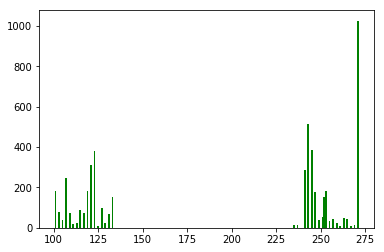

In [7]:
plt.bar(counter.keys(), counter.values(), width=1.0, color='g')
plt.show()

In [8]:
industry_dic = pd.Series(list_sectors_major_df['industry_name'].values,index = list_sectors_major_df['industry_id']).to_dict()
industry_dic

{101: 'Foods',
 103: 'Textile Products',
 105: 'Pulp & Paper',
 107: 'Chemicals',
 109: 'Drugs',
 111: 'Petroleum',
 113: 'Rubber Products',
 115: 'Stone&Clay & Glass Products',
 117: 'Iron & Steel',
 119: 'Non ferrous Metal & Metal Products',
 121: 'Machinery',
 123: 'Electric & Electronic Equipment',
 125: 'Shipbuilding & Repairing',
 127: 'Motor Vehicles & Auto Parts',
 129: 'Transportation Equipment',
 131: 'Precision Equipment',
 133: 'Other Manufacturing',
 235: 'Fish & Marine Products',
 237: 'Mining',
 241: 'Construction',
 243: 'Wholesale Trade',
 245: 'RetailTrade',
 247: 'Banks',
 249: 'Securities houses',
 251: 'Insurance',
 252: 'Credit & Leasing',
 253: 'Real Estate',
 255: 'Railroad Transportation',
 257: 'Trucking ',
 259: 'Sea Transportation',
 261: 'Air Transportation',
 263: 'Warehousing & Harbor Transportation',
 265: 'Communication Services',
 267: 'Utilities - Electric',
 269: 'Utilities - Gas',
 271: 'Services'}

#### Version 1: 5 sectors
From personal observation, we think these 5 categories can properly include all industries. 
1. consumer products
2. manufacturing
3. technology
4. energy and utilities
5. services

In [9]:
category_name_dic_v1 ={
 'Consumer_products':['Wholesale Trade','Fish & Marine Products','Foods'],
 'Manufacturing': ['Other Manufacturing','Chemicals','Drugs','Pulp & Paper','Rubber Products',
                   'Stone&Clay & Glass Products','Iron & Steel','Non ferrous Metal & Metal Products',
                   'Machinery','Textile Products','Electric & Electronic Equipment','Precision Equipment',
                   'Transportation Equipment','Electric & Electronic Equipment','Construction',
                   'Shipbuilding & Repairing'],
 'Technology':['RetailTrade','Motor Vehicles & Auto Parts','Railroad Transportation','Trucking ',
               'Sea Transportation','Air Transportation','Warehousing & Harbor Transportation','Petroleum'],
 'Energy_Utilities':['Mining','Utilities - Electric','Utilities - Gas'],
 'Services':['Credit & Leasing','Banks','Securities houses','Insurance','Services','Communication Services',
             'Real Estate']}

#### Veriosn 2: 4 sectors:
From economic point of view, we can categorize industries into these 4 sectors.
1. Light industries: <br >
Usually are less capital. It typically produces smaller consumer goods. Most light industry products are produced for end users rather than as intermediates for use by other industries. Light industry facilities typically have less environmental impact than those associated with heavy industry. 
2. Heavy industries: <br >
Heavy industry is industry that involves one or more characteristics such as large and heavy products; large and heavy equipment and facilities; or complex or numerous processes.
3. Service industries: <br >
Industries made up of companies that primarily earn revenue through providing intangible products and services.
Service industry companies are involved in retail, transport, distribution, food services, as well as other service-dominated businesses.
4. Intellectual services industries:  <br >
Intellectual industries provides information services, such as computing and ICT (information and communication technologies), consultancy (offering advice to businesses) and R&D (research, particularly in scientific fields).

references: <br >
https://en.wikipedia.org/wiki/Light_industry#Industry_sectors<br >
https://en.wikipedia.org/wiki/Outline_of_industry#Industry_sectors<br >
https://www.investopedia.com/terms/t/tertiaryindustry.asp<br >

In [10]:
category_name_dic_v2 = { 'Light':['Foods','Textile Products','Pulp & Paper','Rubber Products','Drugs',
                             'Stone&Clay & Glass Products','Non ferrous Metal & Metal Products',
                             'Other Manufacturing','Fish & Marine Products'],
                      'Heavy':['Mining','Chemicals','Petroleum','Iron & Steel','Machinery','Construction',
                               'Shipbuilding & Repairing','Transportation Equipment','Precision Equipment',
                               'Electric & Electronic Equipment'],
                      'Service':['Wholesale Trade','RetailTrade','Railroad Transportation','Trucking ',
                                 'Sea Transportation','Air Transportation','Warehousing & Harbor Transportation',
                                 'Communication Services','Motor Vehicles & Auto Parts','Utilities - Electric',
                                 'Utilities - Gas'],
                      'Intellectual services':['Banks','Securities houses','Insurance','Credit & Leasing',
                                               'Real Estate','Services'] }

#### Version 3 :
From the perspective of product/service process, we can categorize industries into 5 sectoes. The upstream is raw material, as process going to downstream, company deliver servive to the end users.
1. raw_materials
2. equipment
3. manufacturing_prodcution
4. services
5. corporate_related

In [11]:
category_name_dic_v3 = {'raw_materials':['Pulp & Paper','Chemicals','Petroleum','Iron & Steel',
                                           'Fish & Marine Products','Mining'],

                        'equipment':['Machinery','Electric & Electronic Equipment','Transportation Equipment',
                                     'Precision Equipment','Air Transportation',
                                     'Warehousing & Harbor Transportation'],

                        'manufacturing_prodcution':['Textile Products','Drugs','Rubber Products',
                                                    'Stone&Clay & Glass Products',
                                                    'Non ferrous Metal & Metal Products','Other Manufacturing'],

                        'services':['Shipbuilding & Repairing','Construction','Railroad Transportation',
                                      'Trucking ','Sea Transportation','Communication Services',
                                      'Utilities - Electric','Utilities - Gas','Services','Foods'],

                        'corporate_related':['Wholesale Trade','RetailTrade','Banks','Securities houses',
                                             'Insurance','Credit & Leasing','Real Estate',
                                             'Motor Vehicles & Auto Parts']
                       }


### Generate company_industry dataframes according to different category definitions

In [12]:
# convert industries' names into codes
def convert_industry_code(sub_name_list):
    code_list = list(industry_dic.keys()) 
    name_list = list(industry_dic.values())
    
    sub_code_list = []
    for industry_name in sub_name_list:
        if industry_name in industry_dic.values():
            industry_code =code_list[name_list.index(industry_name)]
        else:
            industry_code = None
        sub_code_list.append(industry_code)    

    return sub_code_list

In [13]:
# get a dictionary of {category: codes}
def get_category_code(category_name_dic):
    category_code_dic = {}
    for key, value in category_name_dic.items():
        code_list = convert_industry_code(value)
        category_code_dic.update({key:code_list})
    return category_code_dic

In [14]:
# get category for each company
def get_industry_category(row,category_code_dic):
    for category, code_list in category_code_dic.items():
        if row['industry_id'] in code_list:
            return category

In [15]:
# get a dataframe of company, industry, and its category 
def get_category_df(category_name_dic):
    category_code_dic = get_category_code(category_name_dic)
    df = ncc_sect_major_df.copy()
    df['industry_category'] = df.apply (lambda row: get_industry_category(row,category_code_dic), axis=1)
    return df

In [16]:
ncc_sect_major_df_1 = get_category_df(category_name_dic_v1)
ncc_sect_major_df_2 = get_category_df(category_name_dic_v2)
ncc_sect_major_df_3 = get_category_df(category_name_dic_v3)

In [17]:
ncc_sect_major_df_1

,Company,industry_id,industry_category
0,1,235,Consumer_products
1,2,235,Consumer_products
2,3,235,Consumer_products
3,4,235,Consumer_products
4,5,235,Consumer_products
5,6,243,Consumer_products
6,11,237,Energy_Utilities
7,13,237,Energy_Utilities
8,15,271,Services
9,16,243,Consumer_products


In [18]:
ncc_sect_major_df_1.groupby("industry_category").count()

,Company,industry_id
industry_category,,
Consumer_products,709,709
Energy_Utilities,39,39
Manufacturing,2033,2033
Services,1670,1670
Technology,665,665


In [19]:
ncc_sect_major_df_2

,Company,industry_id,industry_category
0,1,235,Light
1,2,235,Light
2,3,235,Light
3,4,235,Light
4,5,235,Light
5,6,243,Service
6,11,237,Heavy
7,13,237,Heavy
8,15,271,Intellectual services
9,16,243,Service


In [20]:
ncc_sect_major_df_3

,Company,industry_id,industry_category
0,1,235,raw_materials
1,2,235,raw_materials
2,3,235,raw_materials
3,4,235,raw_materials
4,5,235,raw_materials
5,6,243,corporate_related
6,11,237,raw_materials
7,13,237,raw_materials
8,15,271,services
9,16,243,corporate_related


### Generate dataframes that can be used to generate scatter plot with x=asset, y = nodes 

In [21]:
useful_asset_items = ['B01021','B01022','B01023','B01025','B01034','B01039','B01041','B01062',
                      'B01063','B01065','B01075','B01084','B01085','B01086','B01097','B01098',
                      'B01101','B01110']
ass_con_df = pd.merge(connections_df, assets_df, how='inner', on=['Year', 'Company'])

def scatter_plot_df_generator(ncc_sect_major_df):
    final_df = ass_con_df.copy()
    final_df = pd.merge(final_df, ncc_sect_major_df, how= 'left', on=['Company'])
    final_df[['Year','Company','Degree','industry_category']+useful_asset_items+['industry_id']].query("Year==2000")
    return final_df

In [22]:
scatter_plot_df_1 = scatter_plot_df_generator(ncc_sect_major_df_1)
scatter_plot_df_2 = scatter_plot_df_generator(ncc_sect_major_df_2)
scatter_plot_df_3 = scatter_plot_df_generator(ncc_sect_major_df_3)

In [23]:
#df = scatter_plot_df_2
#scatter_plot_df_2['industry_category'].isnull().sum()
#df[df['industry_category'].isnull()].index.tolist()
#df.iloc[[7727]]

### Generate one scatter plot (log) with all industry categories

In [24]:
# generate one scatter plot with all industry categories
def scatter_plot_generator_all(df, asset_item):
    ax = sns.scatterplot(x= asset_item, y="Degree", data = df, hue='industry_category')
    sns.set(rc={'figure.figsize':(12,8)})
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.show()

In [25]:
scatter_plot_df_1.groupby("industry_category").count()

,Year,Company,Degree,B01021,B01112,B01022,B01023,B01024,B01025,B01026,...,B01102,B01103,B01104,B01105,B01106,B01107,B01108,B01109,B01110,industry_id
industry_category,,,,,,,,,,,,,,,,,,,,,
Consumer_products,4671,4671,4671,4671,0,4670,4606,4068,4604,0,...,4172,124,326,53,27,270,0,0,4671,4671
Energy_Utilities,304,304,304,304,0,304,303,193,303,0,...,267,9,73,21,45,12,0,0,304,304
Manufacturing,13866,13866,13866,13866,0,13866,13708,13292,13683,0,...,11832,442,1031,260,158,708,0,0,13866,13866
Services,7304,7304,7304,7304,0,7304,6828,2399,6790,0,...,4454,130,1062,110,52,944,0,0,7304,7304
Technology,4847,4847,4847,4847,0,4847,4706,2426,4706,0,...,3752,127,519,84,48,405,0,0,4847,4847


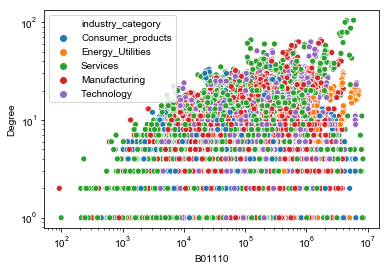

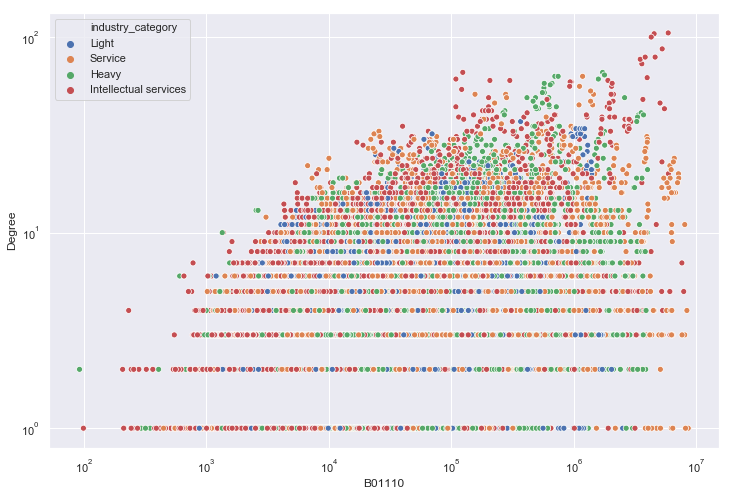

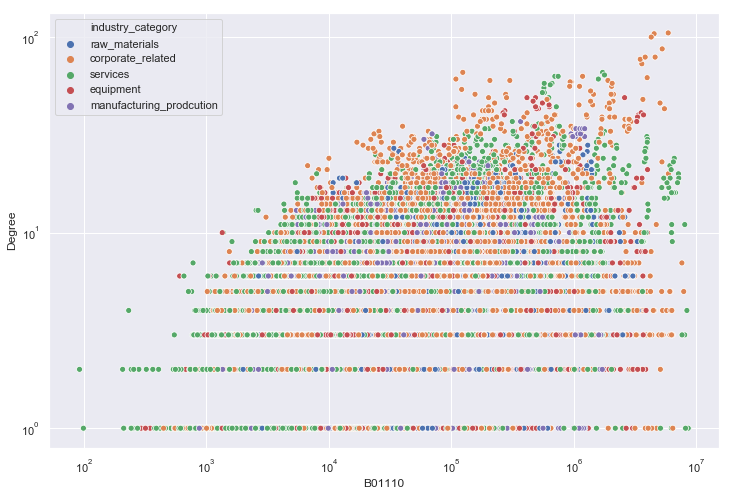

In [26]:
asset_item = "B01110"
scatter_plot_generator_all(scatter_plot_df_1, asset_item)
scatter_plot_generator_all(scatter_plot_df_2, asset_item)
scatter_plot_generator_all(scatter_plot_df_3, asset_item)

### Generate one scatter plot (log) with one industry category

In [31]:
scatter_plot_df_1['log(B01110)'] = np.log(scatter_plot_df_1['B01110'])
scatter_plot_df_1['log(Degree)'] = np.log(scatter_plot_df_1['Degree'])

scatter_plot_df_2['log(B01110)'] = np.log(scatter_plot_df_2['B01110'])
scatter_plot_df_2['log(Degree)'] = np.log(scatter_plot_df_2['Degree'])

scatter_plot_df_3['log(B01110)'] = np.log(scatter_plot_df_3['B01110'])
scatter_plot_df_3['log(Degree)'] = np.log(scatter_plot_df_3['Degree'])

In [28]:
# generate one scatter plot(log log) with one industry category
def scatter_plot_generator_one_log_log(df, log_asset_item, industry_category ):
    ax = sns.scatterplot(x= log_asset_item, y='log(Degree)', data=df.loc[df['industry_category'] == industry_category])
    sns.set(rc={'figure.figsize':(8,5)})
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend([industry_category])
    plt.show()


In [29]:
# Summary all cases for one category definition
def scatter_plot_generator_one_log_log_2(df,asset_item):
    print("-------Start-------")
    industry_category_list = df['industry_category'].unique().tolist()
    for industry_category in industry_category_list:
        scatter_plot_generator_one_log_log(df, asset_item, industry_category)
    print("-------End-------")

-------Start-------


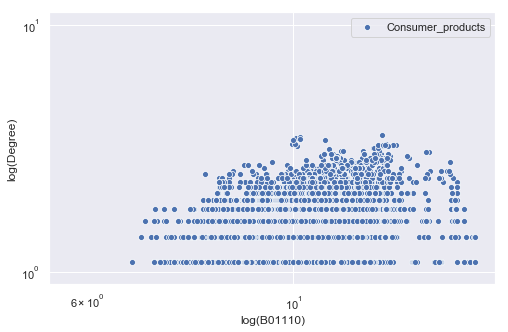

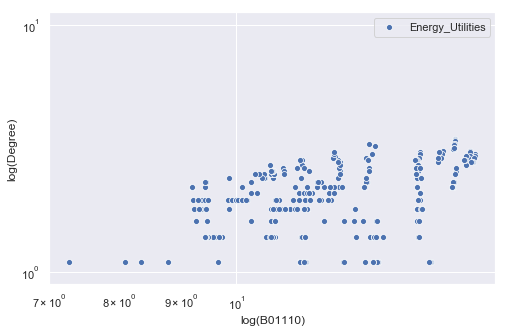

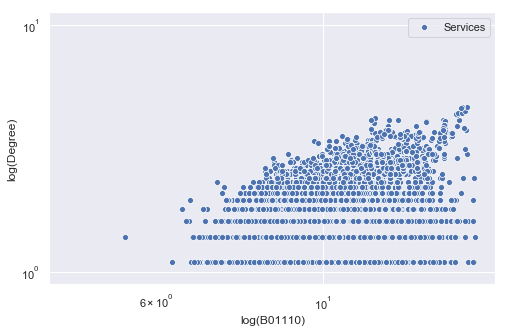

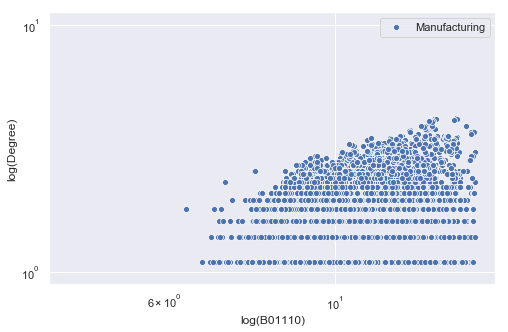

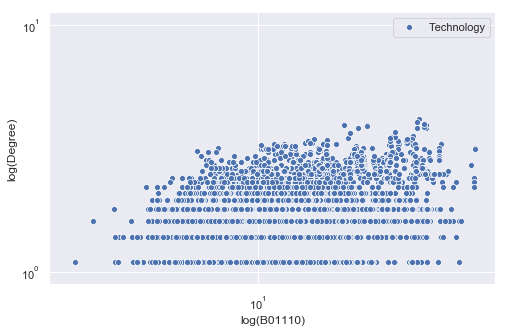

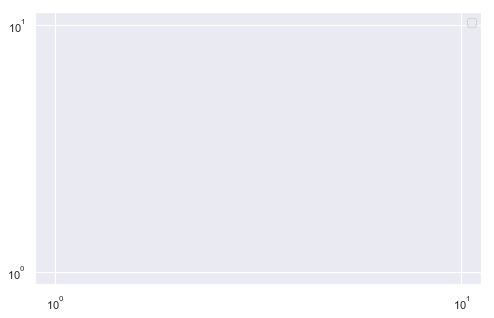

-------End-------
-------Start-------


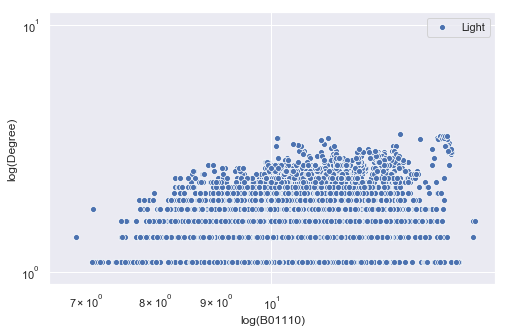

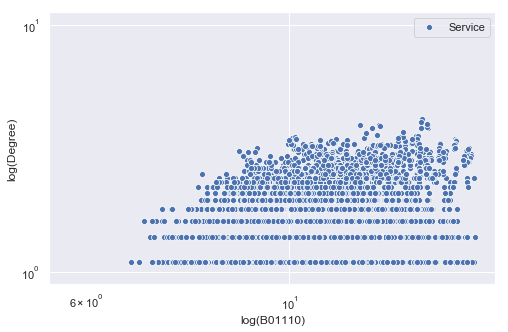

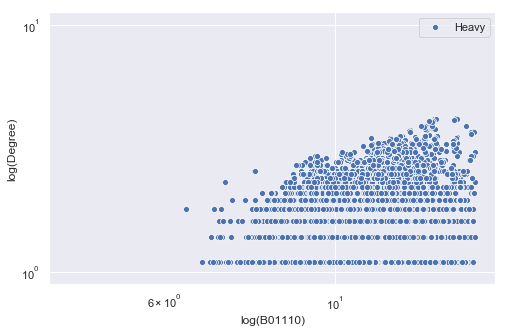

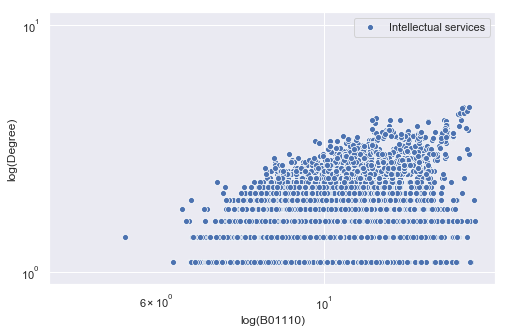

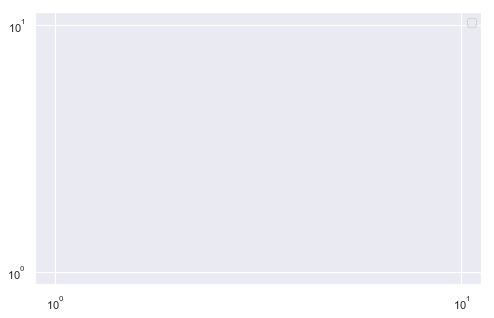

-------End-------
-------Start-------


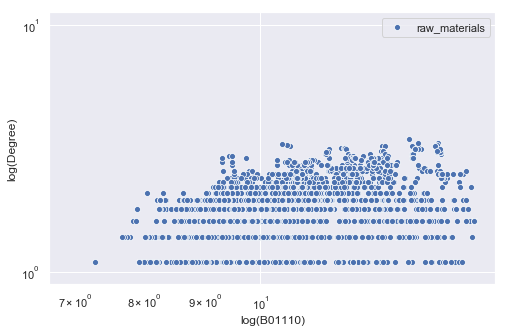

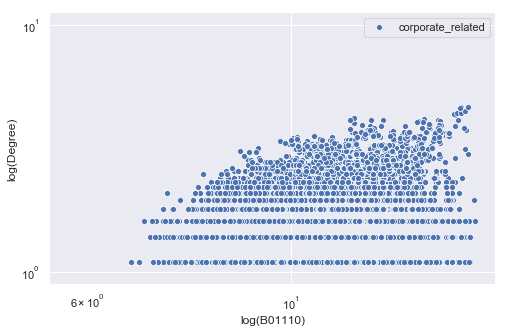

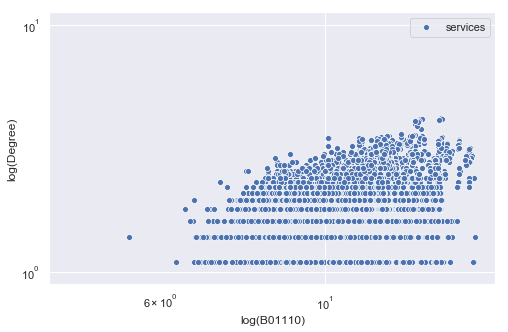

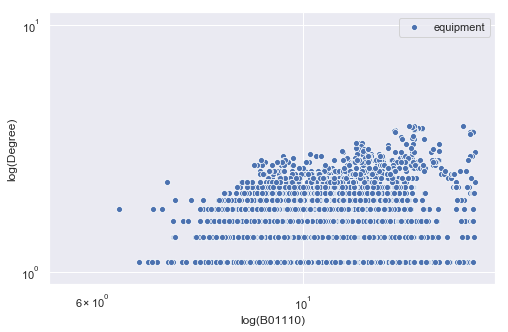

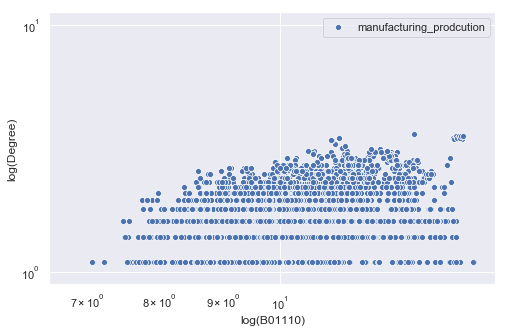

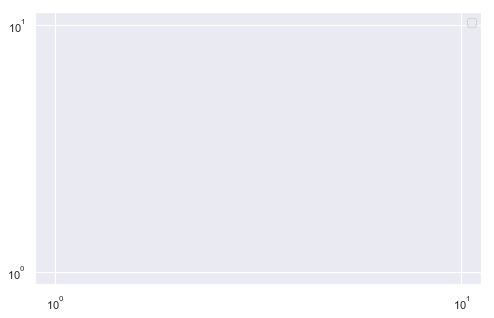

-------End-------


In [32]:
log_asset_item = 'log(B01110)'
scatter_plot_generator_one_log_log_2(scatter_plot_df_1,log_asset_item)
scatter_plot_generator_one_log_log_2(scatter_plot_df_2,log_asset_item)
scatter_plot_generator_one_log_log_2(scatter_plot_df_3,log_asset_item)

In [ ]:
# generate one scatter plot with one industry category
def scatter_plot_generator_one_log(df, asset_item, industry_category ):
    ax = sns.scatterplot(x= asset_item, y="Degree", data=df.loc[df['industry_category'] == industry_category])
    sns.set(rc={'figure.figsize':(8,5)})
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend([industry_category])
    plt.show()

In [ ]:
# Summary all cases for one category definition
def scatter_plot_generator_one_log_2(df,asset_item):
    print("-------Start-------")
    industry_category_list = df['industry_category'].unique().tolist()
    for industry_category in industry_category_list:
        scatter_plot_generator_one_log(df, asset_item, industry_category)
    print("-------End-------")
  

In [ ]:
asset_item = "B01110"
scatter_plot_generator_one_log_2(scatter_plot_df_1,asset_item)
scatter_plot_generator_one_log_2(scatter_plot_df_2,asset_item)
scatter_plot_generator_one_log_2(scatter_plot_df_3,asset_item)

### Generate one scatter plot (no log) with all industry categories

In [ ]:
def scatter_plot_generator_all(df, asset_item):
    sns.lmplot( x= asset_item, y="Degree", data=df, fit_reg=False, hue='industry_category', legend=True) 
    plt.show()

In [ ]:
asset_item = "B01110"
scatter_plot_generator_all(scatter_plot_df_1, asset_item)
scatter_plot_generator_all(scatter_plot_df_2, asset_item)
scatter_plot_generator_all(scatter_plot_df_3, asset_item)

### Generate one scatter plot (no log) with one industry category

In [ ]:
# generate one scatter plot with one industry category
def scatter_plot_generator_one(df, asset_item, industry_category ):
    ax = sns.scatterplot(x= asset_item, y="Degree", data=df.loc[df['industry_category'] == industry_category])
    sns.set(rc={'figure.figsize':(8,5)})
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.legend([industry_category])
    plt.show()

In [ ]:
# Summary all cases for one category definition
def scatter_plot_generator_one_2(df,asset_item):
    print("-------Start-------")
    industry_category_list = df['industry_category'].unique().tolist()
    for industry_category in industry_category_list:
        scatter_plot_generator_one(df, asset_item, industry_category)
    print("-------End-------")
  

In [ ]:
asset_item = "B01110"
scatter_plot_generator_one_2(scatter_plot_df_1,asset_item)
scatter_plot_generator_one_2(scatter_plot_df_2,asset_item)
scatter_plot_generator_one_2(scatter_plot_df_3,asset_item)

### Generate one density scatter plot (log) with one industry category

In [ ]:
# generate one density plot with one industry category
def density_plot_generator_one(df, asset_item, industry_category ):
    data = df.loc[df['industry_category'] == industry_category]
    
    # Generate data
    x = np.log(data[asset_item])
    y = np.log(data['Degree'])
    
    # Calculate the point density
    #xy = np.vstack([x,y])
    #z = gaussian_kde(xy)(xy)
    
    # Print the labels
    plt.xlabel(asset_item)
    plt.ylabel('Degree')
    plt.title(industry_category)

    # Make the plot
    #plt.hexbin(x, y, gridsize=(80,50) )
    plt.hist2d(x, y, (80, 80), cmap=plt.cm.jet)
    plt.colorbar()
    
    plt.show()


In [ ]:
# Summary all cases for one category definition
def density_plot_generator_one_2(df,asset_item):
    print("-------Start-------")
    industry_category_list = df['industry_category'].unique().tolist()[:-1]
    print(industry_category_list)
    for industry_category in industry_category_list:
        density_plot_generator_one(df, asset_item, industry_category)
    print("-------End-------")


In [ ]:
asset_item = "B01110"
density_plot_generator_one_2(scatter_plot_df_1,asset_item)
density_plot_generator_one_2(scatter_plot_df_2,asset_item)
density_plot_generator_one_2(scatter_plot_df_3,asset_item)

### Conclusion
Those compnaies who have high degrees are all in the same category. No matter what definitions we use, the basic idea of this category is “less capital and more intellectual services that are directly served to the end users. “ Examples are Banks, 'Securities houses, Insurance, Credit & Leasing, Real Estate, Services …
